In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

2025-04-10 04:48:46.552527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744260527.044997      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744260527.195480      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Example path - change this to match your folder structure
dataset_path = '/kaggle/input/breastcancer-datasets/Dataset_BUSI/Dataset_BUSI_with_GT'


In [6]:
print("📊 Class-wise image count:\n")
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"{class_name}: {num_images} images")
        

📊 Class-wise image count:

benign: 891 images
normal: 266 images
malignant: 421 images


In [7]:
# Specify only the classes you want to use (benign and malignant)
classes_to_use = ['benign', 'malignant']

In [9]:
import os
import shutil
import random
# Where to create the new split folders
output_dir = '/kaggle/working/split_BUSI_dataset'

# Split ratios (e.g., 70% train, 15% val, 15% test)
split_ratios = (0.7, 0.15, 0.15)
random.seed(42)

for cls in classes_to_use:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(split_ratios[0] * n_total)
    n_val = int(split_ratios[1] * n_total)

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    for split_name, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(output_dir, split_name, cls)
        os.makedirs(split_class_dir, exist_ok=True)
        for file in split_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(split_class_dir, file)
            shutil.copyfile(src, dst)

print("Dataset successfully split into train, val, and test folders.")

Dataset successfully split into train, val, and test folders.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 917 images belonging to 2 classes.
Found 196 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [11]:
print("Class indices:", train_generator.class_indices)


Class indices: {'benign': 0, 'malignant': 1}


In [12]:
# Check a single batch from the train generator
x_batch, y_batch = next(train_generator)

print("Image batch shape:", x_batch.shape)  # (batch_size, IMG_SIZE, IMG_SIZE, 3)
print("Label batch shape:", y_batch.shape)  # (batch_size, 3)
print("First label (one-hot):", y_batch[0])


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 2)
First label (one-hot): [1. 0.]


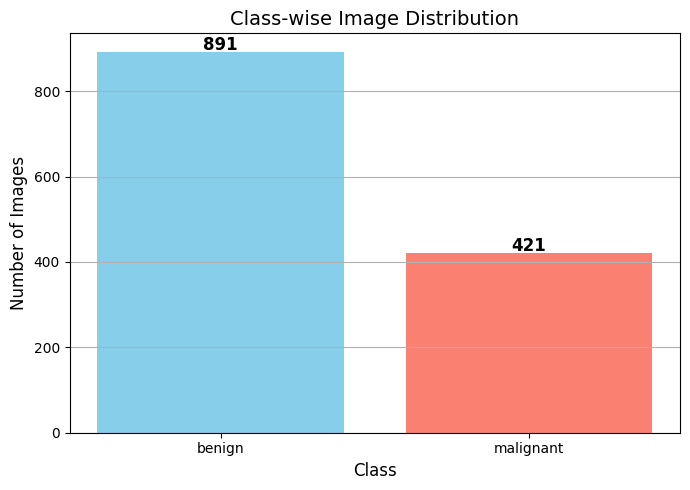

In [13]:
#Class-wise Image Distribution with Counts Displayed
class_names = ['benign', 'malignant']
class_counts = []

for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    count = len(os.listdir(class_dir))
    class_counts.append(count)

plt.figure(figsize=(7, 5))
bars = plt.bar(class_names, class_counts, color=['skyblue', 'salmon', 'lightgreen'])

# 🔢 Add count numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.title('Class-wise Image Distribution', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

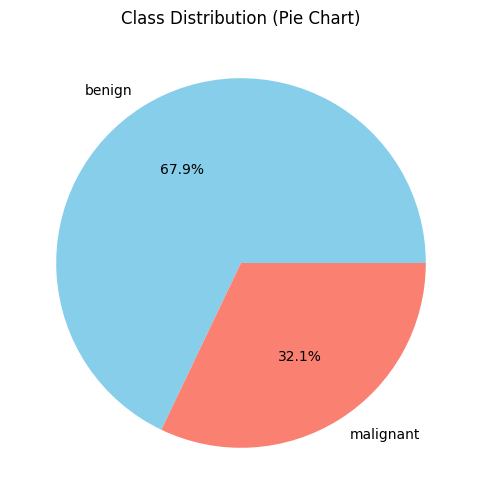

In [14]:
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', colors=['skyblue', 'salmon', 'lightgreen'])
plt.title('Class Distribution (Pie Chart)')
plt.show()


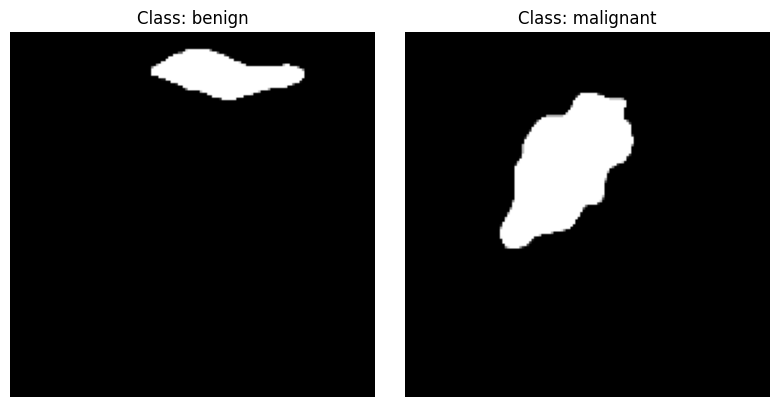

In [15]:
import cv2
import random
import matplotlib.pyplot as plt

random.seed(42)  # Fixed seed for reproducible random choices

plt.figure(figsize=(12, 4))

for i, category in enumerate(class_names):
    folder_path = os.path.join(dataset_path, category)
    images = os.listdir(folder_path)
    img_name = random.choice(images)  # Will always pick the same image now
    img_path = os.path.join(folder_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150, 150))

    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {category}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
#Visualize One Image with Its Augmented Versions
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Augmentation generator
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# 🔁 Function to visualize a single image and its augmentations
def visualize_augmentations(dataset_path, class_names, seed=42, num_augments=8):
    random.seed(seed)

    # Pick a random class
    class_name = random.choice(class_names)
    class_folder = os.path.join(dataset_path, class_name)

    # Pick a random image from that class (reproducible by seed)
    images = os.listdir(class_folder)
    random.seed(seed + 1)  # Change seed slightly to randomize image within same seed
    img_name = random.choice(images)
    img_path = os.path.join(class_folder, img_name)

    # Load and prepare image
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Plot original + augmentations
    plt.figure(figsize=(15, 6))
    plt.subplot(2, num_augments + 1, 1)
    plt.imshow(np.array(img) / 255.0)  # ✅ FIXED: convert PIL image to array before division
    plt.title(f"Original - {class_name}")
    plt.axis('off')

    # Generate augmentations
    i = 1
    for batch in augment_gen.flow(img_array, batch_size=1, seed=seed):
        plt.subplot(2, num_augments + 1, i + 1)
        plt.imshow(batch[0])
        plt.title(f"Augmented {i}")
        plt.axis('off')
        i += 1
        if i > num_augments:
            break

    plt.suptitle("Single Image and Its Augmented Versions", fontsize=16)
    plt.tight_layout()
    plt.show()


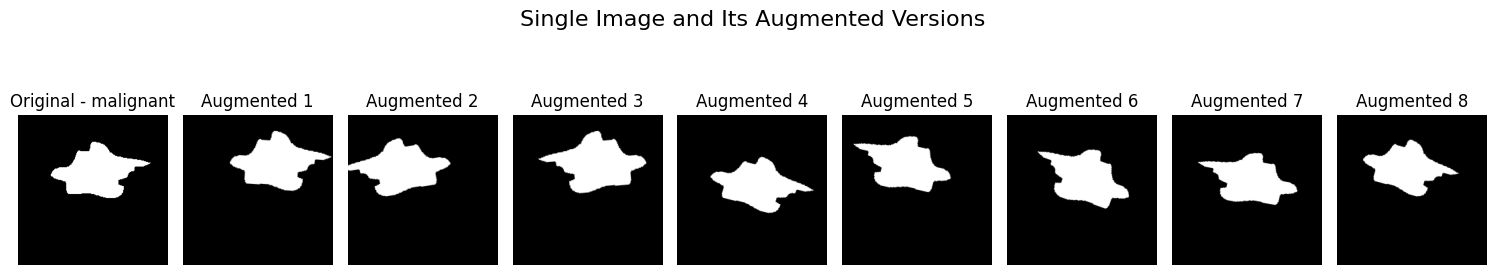

In [17]:
visualize_augmentations(dataset_path, class_names, seed=40, num_augments=8)


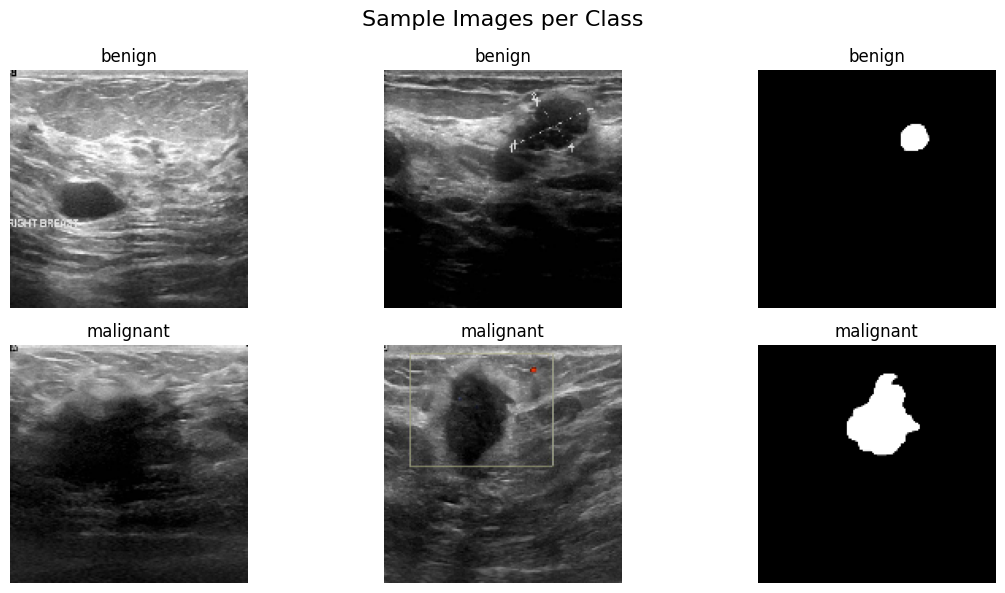

In [18]:
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_names):
    folder_path = os.path.join(dataset_path, class_name)
    images = os.listdir(folder_path)
    for j in range(3):  # Show 3 images per class
        img_path = os.path.join(folder_path, images[j])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150, 150))

        plt.subplot(len(class_names), 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name}")
        plt.axis('off')

plt.suptitle("Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.show()


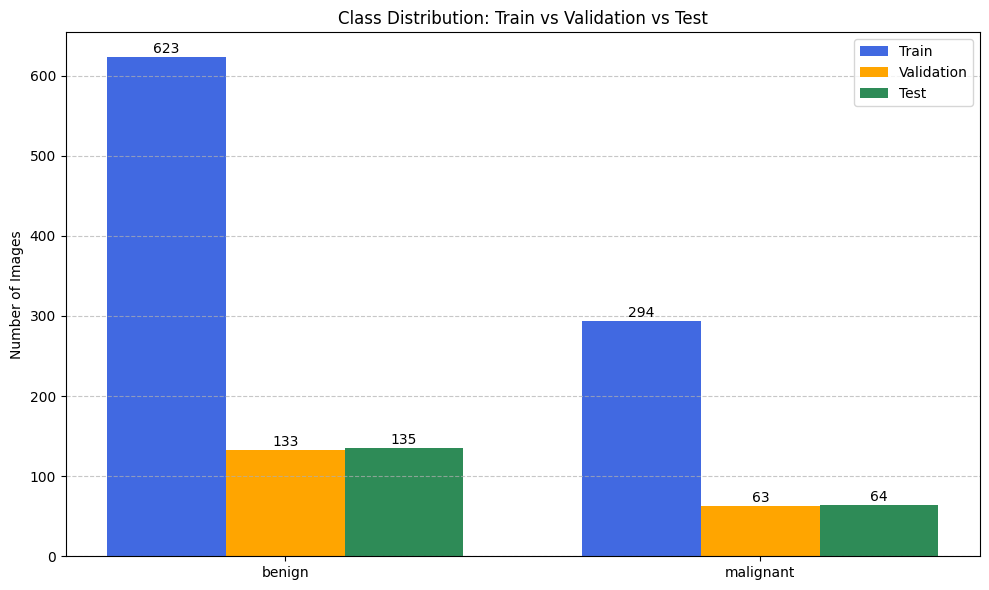

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Count images per class in each generator
train_counts = np.bincount(train_generator.classes)
val_counts = np.bincount(val_generator.classes)
test_counts = np.bincount(test_generator.classes)

# Class labels
x_labels = list(train_generator.class_indices.keys())

# Set bar width and position
x = np.arange(len(x_labels))
bar_width = 0.25

plt.figure(figsize=(10, 6))

# Plot bars
bars1 = plt.bar(x - bar_width, train_counts, width=bar_width, label='Train', color='royalblue')
bars2 = plt.bar(x, val_counts, width=bar_width, label='Validation', color='orange')
bars3 = plt.bar(x + bar_width, test_counts, width=bar_width, label='Test', color='seagreen')

# Add count labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), 
                 ha='center', va='bottom', fontsize=10)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Labels and aesthetics
plt.xticks(x, x_labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution: Train vs Validation vs Test")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.utils import class_weight
import numpy as np

# Assuming 'y_train' is the labels used in your training generator
y_train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.7359550561797753, 1: 1.5595238095238095}


In [21]:
from tensorflow.keras.applications import MobileNetV2, DenseNet121, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

def build_mobilenet_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("\n-------- MobileNetV2 Model Summary --------")
    model.summary()
    return model








In [22]:
def build_densenet_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("\n-------- DenseNet121 Model Summary --------")
    model.summary()
    return model

In [31]:

def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("\n-------- ResNet50 Model Summary --------")
    model.summary()
    return model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def train_model(model, model_name):
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=40,
        callbacks=[checkpoint, reduce_lr, early_stop],
        class_weight=class_weights_dict
    )
    return history


In [26]:
mobilenet_model = build_mobilenet_model()
mobilenet_history = train_model(mobilenet_model, "MobileNetV2")




I0000 00:00:1744262452.470362      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744262452.471096      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

-------- MobileNetV2 Model Summary --------


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,427,330 (9.26 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744262465.422194     165 service.cc:148] XLA service 0x7f03b0001ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744262465.429681     165 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744262465.429707     165 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744262466.574528     165 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/29 ━━━━━━━━━━━━━━━━━━━━ 7:40 16s/step - accuracy: 0.4688 - loss: 1.4055

I0000 00:00:1744262472.910232     165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.7073 - loss: 0.7668
Epoch 1: val_loss improved from inf to 0.35337, saving model to MobileNetV2_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 552ms/step - accuracy: 0.7125 - loss: 0.7517 - val_accuracy: 0.8061 - val_loss: 0.3534 - learning_rate: 0.0010
Epoch 2/40
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8924 - loss: 0.3096
Epoch 2: val_loss improved from 0.35337 to 0.30682, saving model to MobileNetV2_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8920 - loss: 0.3077 - val_accuracy: 0.8571 - val_loss: 0.3068 - learning_rate: 0.0010
Epoch 3/40
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9119 - loss: 0.2356
Epoch 3: val_loss improved from 0.30682 to 0.30568, saving model to MobileNetV2_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.9121 - loss: 0.2349 - val_accuracy: 0.8520 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 4/40
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [27]:
densenet_model = build_densenet_model()
densenet_history = train_model(densenet_model, "DenseNet121")



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

-------- DenseNet121 Model Summary --------


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173,058 (27.36 MB)

 Trainable params: 133,506 (521.51 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7411 - loss: 0.5596
Epoch 1: val_loss improved from inf to 0.34741, saving model to DenseNet121_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7430 - loss: 0.5574 - val_accuracy: 0.8469 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8414 - loss: 0.3665
Epoch 2: val_loss improved from 0.34741 to 0.28844, saving model to DenseNet121_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8422 - loss: 0.3646 - val_accuracy: 0.8673 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8862 - loss: 0.2484
Epoch 3: val_loss improved from 0.28844 to 0.24049, saving model to DenseNet121_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8860 - loss: 0.2486 - val_accuracy: 0.8878 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━

In [32]:
resnet_model = build_resnet_model()
resnet_history = train_model(resnet_model, "ResNet50")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

-------- ResNet50 Model Summary --------


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,434 (91.01 MB)

 Trainable params: 266,626 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6327 - loss: 0.6395
Epoch 1: val_loss improved from inf to 0.56536, saving model to ResNet50_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 641ms/step - accuracy: 0.6352 - loss: 0.6366 - val_accuracy: 0.7041 - val_loss: 0.5654 - learning_rate: 0.0010
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8335 - loss: 0.3639
Epoch 2: val_loss improved from 0.56536 to 0.54857, saving model to ResNet50_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.8328 - loss: 0.3650 - val_accuracy: 0.7041 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8085 - loss: 0.3881
Epoch 3: val_loss improved from 0.54857 to 0.50625, saving model to ResNet50_best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.8089 - loss: 0.3878 - val_accuracy: 0.7755 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s

In [33]:
def summarize_history(history, model_name):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"\n{model_name} - Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    return train_acc, val_acc


In [34]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_on_test(model, model_name):
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")

    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    return test_acc


In [35]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()



DenseNet121 - Training Accuracy: 0.9498, Validation Accuracy: 0.9235
DenseNet121 - Test Accuracy: 0.9397
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step 

Classification Report for DenseNet121:

              precision    recall  f1-score   support

      benign       0.96      0.96      0.96       135
   malignant       0.91      0.91      0.91        64

    accuracy                           0.94       199
   macro avg       0.93      0.93      0.93       199
weighted avg       0.94      0.94      0.94       199



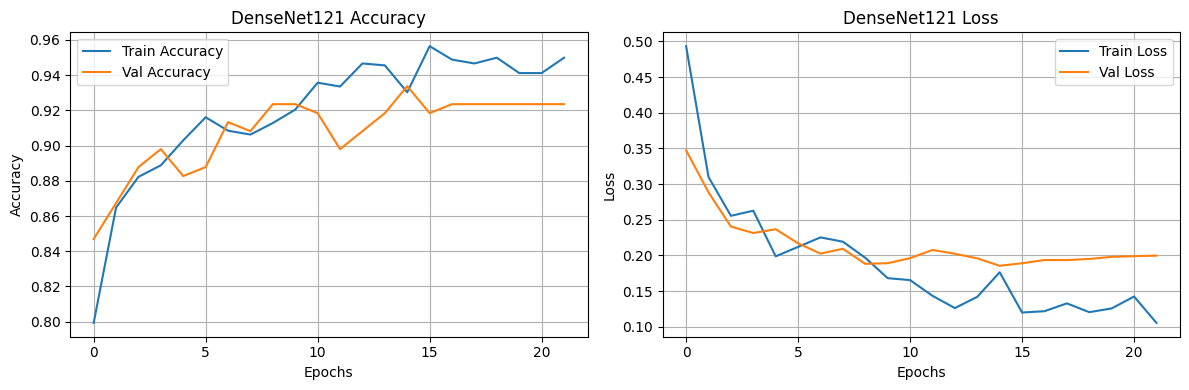


MobileNetV2 - Training Accuracy: 0.9793, Validation Accuracy: 0.9031
MobileNetV2 - Test Accuracy: 0.9196
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 669ms/step

Classification Report for MobileNetV2:

              precision    recall  f1-score   support

      benign       0.93      0.95      0.94       135
   malignant       0.89      0.86      0.87        64

    accuracy                           0.92       199
   macro avg       0.91      0.90      0.91       199
weighted avg       0.92      0.92      0.92       199



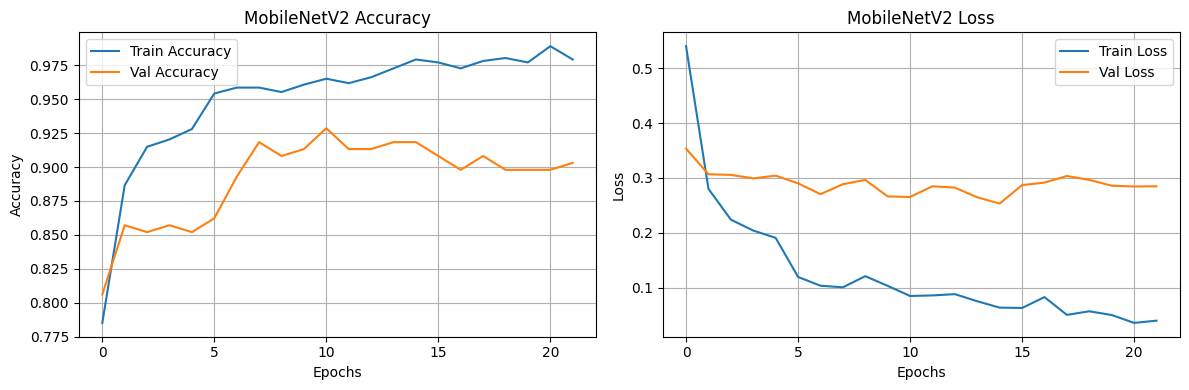


ResNet50 - Training Accuracy: 0.8975, Validation Accuracy: 0.8520
ResNet50 - Test Accuracy: 0.8643
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step

Classification Report for ResNet50:

              precision    recall  f1-score   support

      benign       0.86      0.96      0.91       135
   malignant       0.89      0.66      0.76        64

    accuracy                           0.86       199
   macro avg       0.87      0.81      0.83       199
weighted avg       0.87      0.86      0.86       199



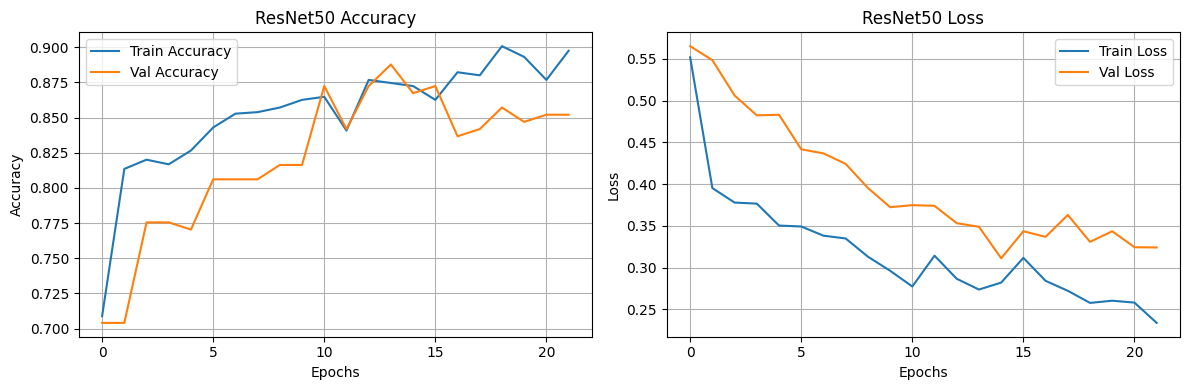


🔍 Best model based on test accuracy: DenseNet121


In [36]:
model_accuracies = {}

# DenseNet
d_train, d_val = summarize_history(densenet_history, "DenseNet121")
d_test = evaluate_on_test(densenet_model, "DenseNet121")
plot_history(densenet_history, "DenseNet121")
model_accuracies["DenseNet121"] = d_test

# MobileNetV2
m_train, m_val = summarize_history(mobilenet_history, "MobileNetV2")
m_test = evaluate_on_test(mobilenet_model, "MobileNetV2")
plot_history(mobilenet_history, "MobileNetV2")
model_accuracies["MobileNetV2"] = m_test

# ResNet50
r_train, r_val = summarize_history(resnet_history, "ResNet50")
r_test = evaluate_on_test(resnet_model, "ResNet50")
plot_history(resnet_history, "ResNet50")
model_accuracies["ResNet50"] = r_test

# Select and save the best model
best_model_name = max(model_accuracies, key=model_accuracies.get)
print(f"\n🔍 Best model based on test accuracy: {best_model_name}")

if best_model_name == "DenseNet121":
    densenet_model.save("ultrasound_breast_cancer_model.h5")
elif best_model_name == "MobileNetV2":
    mobilenet_model.save("ultrasound_breast_cancer_model.h5")
elif best_model_name == "ResNet50":
    resnet_model.save("ultrasound_breast_cancer_model.h5")


In [37]:
print(f"✅ The best model ({best_model_name}) has been saved as 'ultrasound_breast_cancer_model.h5'")

✅ The best model (DenseNet121) has been saved as 'ultrasound_breast_cancer_model.h5'


In [ ]:
# Importing Necessary Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
# Image Parameters
img_height, img_width = 224, 224  
batch_size = 32

In [93]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Paths
source_dir = '/kaggle/input/breastcancer-datasets/Breast Cancer Patients MRI/Breast Cancer Patients MRI'
output_dir = '/kaggle/working/split_MRI_dataset'

# Make sure this matches the actual class folder names inside your source_dir
classes_to_use = ['Benign', 'Malignant']

# Create target dirs
for split in ['train', 'val', 'test']:
    for cls in classes_to_use:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split and copy images
for cls in classes_to_use:
    cls_dir = os.path.join(source_dir, cls)
    all_images = os.listdir(cls_dir)
    random.shuffle(all_images)

    train_files, temp_files = train_test_split(all_images, train_size=train_ratio, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    for img in train_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'train', cls, img))

    for img in val_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'val', cls, img))

    for img in test_files:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(output_dir, 'test', cls, img))

print("✅ MRI dataset successfully split into train, validation, and test sets!")


✅ MRI dataset successfully split into train, validation, and test sets!


In [94]:
# Create a datagen with only rescaling
datagen = ImageDataGenerator(rescale=1.0/255)

# Train generator
train_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=['Benign', 'Malignant']
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Benign', 'Malignant']
)

# Test generator
test_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Benign', 'Malignant']
)

Found 1478 images belonging to 2 classes.
Found 925 images belonging to 2 classes.
Found 911 images belonging to 2 classes.


In [95]:
print("Class indices:", train_generator.class_indices)


Class indices: {'Benign': 0, 'Malignant': 1}


In [96]:
print("📊 Image Counts in Each Class:")
total = 0
for cls in classes_to_use:
    cls_path = os.path.join(source_dir, cls)
    num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    total += num_images
    print(f"🔹 {cls}: {num_images} images")

📊 Image Counts in Each Class:
🔹 Benign: 740 images
🔹 Malignant: 740 images


In [97]:
from tensorflow.keras.applications import EfficientNetB0
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [100]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=2):
    # Load the base EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

def train_model(model, model_name):
    checkpoint = ModelCheckpoint(f"{model_name}_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=40,
        callbacks=[checkpoint, reduce_lr, early_stop],
        class_weight=class_weights_dict
    )
    return history


In [103]:
efficientnet_mri_model = build_efficientnet_model()
efficientnet_mri_history = train_model(efficientnet_mri_model, "Efficientnet")


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5196 - loss: 0.7271
Epoch 1: val_loss improved from inf to 0.88875, saving model to Efficientnet_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 48s 502ms/step - accuracy: 0.5191 - loss: 0.7272 - val_accuracy: 0.3214 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5071 - loss: 0.7264
Epoch 2: val_loss improved from 0.88875 to 0.84621, saving model to Efficientnet_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.5070 - loss: 0.7266 - val_accuracy: 0.3214 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4989 - loss: 0.7279
Epoch 3: val_loss did not improve from 0.84621
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4989 - loss: 0.7279 - val_accuracy: 0.3214 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 4/40
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4690 - loss: 0.7296
Epoch 4: 

In [104]:
densenet_mri_model = build_densenet_model()
densenet_mri_history = train_model(densenet_mri_model, "DenseNet121_MRI")



-------- DenseNet121 Model Summary --------


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173,058 (27.36 MB)

 Trainable params: 133,506 (521.51 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5842 - loss: 0.9170
Epoch 1: val_loss improved from inf to 0.79041, saving model to DenseNet121_MRI_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 705ms/step - accuracy: 0.5856 - loss: 0.9133 - val_accuracy: 0.5102 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8115 - loss: 0.4119
Epoch 2: val_loss did not improve from 0.79041
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8119 - loss: 0.4110 - val_accuracy: 0.4490 - val_loss: 1.0330 - learning_rate: 0.0010
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8792 - loss: 0.2823
Epoch 3: val_loss did not improve from 0.79041
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8793 - loss: 0.2820 - val_accuracy: 0.4592 - val_loss: 1.2652 - learning_rate: 0.0010
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9108 - loss: 0.2162
Epoch 4: val_loss did not improve from 0.79041

In [105]:
resnet_mri_model = build_resnet_model()
resnet_mri_history = train_model(resnet_mri_model, "ResNet50_MRI")


-------- ResNet50 Model Summary --------


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,858,434 (91.01 MB)

 Trainable params: 266,626 (1.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5932 - loss: 0.8654
Epoch 1: val_loss improved from inf to 0.60797, saving model to ResNet50_MRI_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.5944 - loss: 0.8621 - val_accuracy: 0.6786 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7640 - loss: 0.4889
Epoch 2: val_loss improved from 0.60797 to 0.59719, saving model to ResNet50_MRI_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.7641 - loss: 0.4885 - val_accuracy: 0.7092 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8134 - loss: 0.3865
Epoch 3: val_loss did not improve from 0.59719
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8134 - loss: 0.3865 - val_accuracy: 0.7143 - val_loss: 0.6037 - learning_rate: 0.0010
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8378 - loss: 0.3

In [112]:
# Assuming you have test_generator already set up
test_loss, test_accuracy = resnet_mri_model.evaluate(test_generator)
print(f"Test Accuracy on MRI dataset (ResNet50): {test_accuracy:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.8277 - loss: 0.4616
Test Accuracy on MRI dataset (ResNet50): 0.5148


In [106]:
mobilenet_mri_model = build_mobilenet_model()
mobilenet_mri_history = train_model(mobilenet_mri_model, "MobileNetV2") 





-------- MobileNetV2 Model Summary --------


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,427,330 (9.26 MB)

 Trainable params: 166,786 (651.51 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/40
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6288 - loss: 1.0311
Epoch 1: val_loss improved from inf to 0.74125, saving model to MobileNetV2_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.6327 - loss: 1.0171 - val_accuracy: 0.6173 - val_loss: 0.7412 - learning_rate: 0.0010
Epoch 2/40
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8566 - loss: 0.3341
Epoch 2: val_loss did not improve from 0.74125
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8576 - loss: 0.3319 - val_accuracy: 0.4082 - val_loss: 1.1745 - learning_rate: 0.0010
Epoch 3/40
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9327 - loss: 0.1829
Epoch 3: val_loss did not improve from 0.74125
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9326 - loss: 0.1829 - val_accuracy: 0.4337 - val_loss: 1.6168 - learning_rate: 0.0010
Epoch 4/40
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9564 - loss: 0.1154
Epoch 4: val_loss did not improve from 0.74125

Ep

In [110]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
#                                      Dropout, Dense, BatchNormalization, Add, Activation)

# def residual_block(x, filters, kernel_size=3):
#     shortcut = x
#     x = Conv2D(filters, kernel_size, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, kernel_size, padding='same')(x)
#     x = BatchNormalization()(x)
    
#     # Add residual connection
#     x = Add()([shortcut, x])
#     x = Activation('relu')(x)
#     return x

# def build_custom_mri_cnn(input_shape=(224, 224, 1), num_classes=2):
#     inputs = Input(shape=input_shape)

#     # Block 1
#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Block 2
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Residual Block
#     x = residual_block(x, 64)

#     # Block 3
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Block 4
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Global Pooling and Dense Layers
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.4)(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dropout, Dense, BatchNormalization, Add, Activation,
                                     Reshape, multiply)

# Residual Block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# SE Block (Attention)
def se_block(input_tensor, ratio=8):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return multiply([input_tensor, se])

# Full Model
def build_advanced_mri_cnn(input_shape=(224, 224, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = residual_block(x, 64)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 4
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D((2, 2))(x)

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



Epoch 1/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5569 - loss: 0.8138
Epoch 1: val_loss improved from inf to 0.63179, saving model to CNN_MRI_best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.5573 - loss: 0.8122 - val_accuracy: 0.6786 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6358 - loss: 0.6032
Epoch 2: val_loss did not improve from 0.63179
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.6361 - loss: 0.6032 - val_accuracy: 0.6786 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7054 - loss: 0.5591
Epoch 3: val_loss did not improve from 0.63179
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7055 - loss: 0.5591 - val_accuracy: 0.4796 - val_loss: 1.0326 - learning_rate: 0.0010
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7077 - loss: 0.5317
Epoch 4: val_loss did not improve from 0.63179

Epoch 